In [31]:
import sys
sys.path.insert(0, r'C:\Users\buzga\Desktop\School\Reaserch\Langone\ML_RA_EHR\DataModule')
sys.path.insert(0, r'C:\Users\buzga\Desktop\School\Reaserch\Langone\ML_RA_EHR')
import matplotlib.pyplot as plt
import Data_Preparation
import evaluate 
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [32]:
## importing data. 
path=r'C:\Users\buzga\Desktop\School\Reaserch\Langone\ML_RA_EHR\Dataset'
df = Data_Preparation.CoronnaCERTAINDataset(
    library_root=path,
    challenge="two_stage", #option: regression, classification, two_stage
    dataset='CORRONA CERTAIN', 
    process_approach='SC', #option: KVB, SC
    imputation='KNN', #option: SimpleFill, KNN, SoftImpute, BiScaler, NuclearNormMinimization, IterativeImputer, IterativeSVD
    patient_group='bionaive TNF', #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia", "KVB"
    drug_group='all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points=(0,3), 
    train_test_rate=0.8,
    save_csv=False, 
    random_state=2022)

train, train_loc = df.get_train()
test, test_loc = df.get_test()
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]
print("x_train shape is ", X_train.shape)
print("y_train shape is ", y_train.shape)
print("x_test shape is ", X_test.shape)
print("y_test shape is ", y_test.shape)

feature engineering, drop columns due to 70% missing value: Index(['smkyrs', 'numcigs', 'rfstatus_impute', 'ccpstatus_impute',
       'statin_use'],
      dtype='object')
Imputing row 1/1498 with 0 missing, elapsed time: 0.347
Imputing row 101/1498 with 1 missing, elapsed time: 0.348
Imputing row 201/1498 with 0 missing, elapsed time: 0.348
Imputing row 301/1498 with 0 missing, elapsed time: 0.349
Imputing row 401/1498 with 0 missing, elapsed time: 0.349
Imputing row 501/1498 with 1 missing, elapsed time: 0.350
Imputing row 601/1498 with 0 missing, elapsed time: 0.350
Imputing row 701/1498 with 0 missing, elapsed time: 0.350
Imputing row 801/1498 with 0 missing, elapsed time: 0.351
Imputing row 901/1498 with 0 missing, elapsed time: 0.351
Imputing row 1001/1498 with 1 missing, elapsed time: 0.352
Imputing row 1101/1498 with 0 missing, elapsed time: 0.353
Imputing row 1201/1498 with 0 missing, elapsed time: 0.353
Imputing row 1301/1498 with 0 missing, elapsed time: 0.354
Imputing row 14

In [33]:
ridge_model = linear_model.RidgeCV()
ridge_model.fit(X_train,y_train)
ridge_preds=ridge_model.predict(X_test)
    

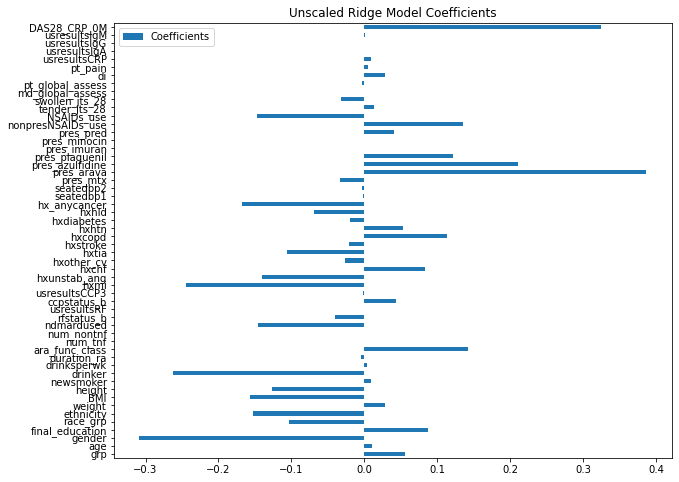

In [34]:
coefs = pd.DataFrame(
   ridge_model.coef_,columns=['Coefficients'],
    index=X_train.columns
)
coefs.plot(kind='barh', figsize=(10, 8))
plt.title('Unscaled Ridge Model Coefficients')
plt.show()

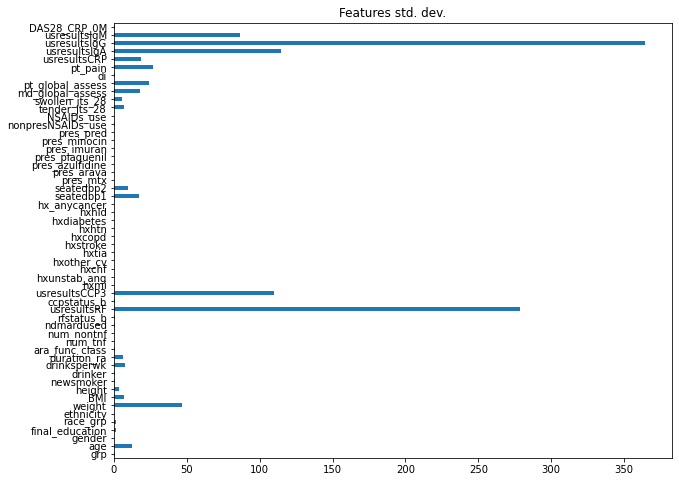

In [35]:
X_train.std(axis=0).plot(kind='barh', figsize=(10, 8))
plt.title('Features std. dev.')
plt.show()

model score on training data: 0.40192011209711764
model score on testing data: 0.19993971782057307


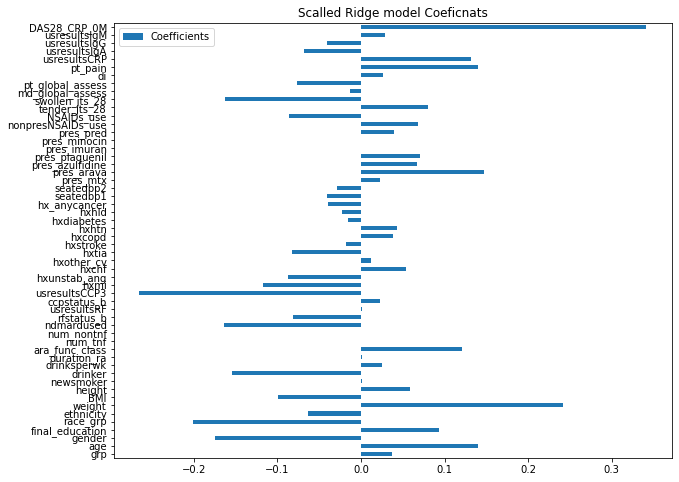

In [36]:
ridge_model = make_pipeline(StandardScaler(), linear_model.RidgeCV())
ridge_model.fit(X_train, y_train)
print(f'model score on training data: {ridge_model.score(X_train, y_train)}')
print(f'model score on testing data: {ridge_model.score(X_test, y_test)}')
coefs = pd.DataFrame(
   ridge_model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)
coefs.plot(kind='barh', figsize=(10,8))
plt.title('Scalled Ridge model Coeficnats')
plt.show()

model score on training data: 0.3898644455541871
model score on testing data: 0.2519750039853035


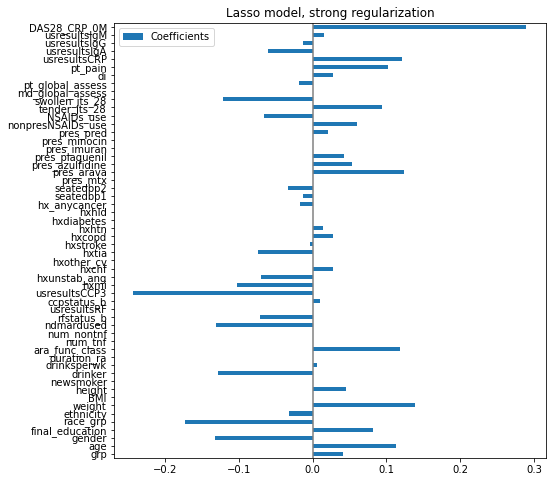

In [37]:
   
lASSO = make_pipeline(StandardScaler(), linear_model.Lasso(alpha=.015))

lASSO.fit(X_train, y_train)
coefs = pd.DataFrame(
   lASSO[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(10,8))
plt.title('Lasso model, strong regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
print(f'model score on training data: {lASSO.score(X_train, y_train)}')
print(f'model score on testing data: {lASSO.score(X_test, y_test)}')

In [38]:
ridge_base = linear_model.RidgeCV()
ridge_base.fit(X_train,y_train)
ridge_base_preds=ridge_base.predict(X_test)
Lasso_base_model = linear_model.Lasso()
Lasso_base_model.fit(X_train,y_train)
laso_base_preds=Lasso_base_model.predict(X_test)

Text(0.5, 1.0, 'Random Forrest Learned Feature Importance')

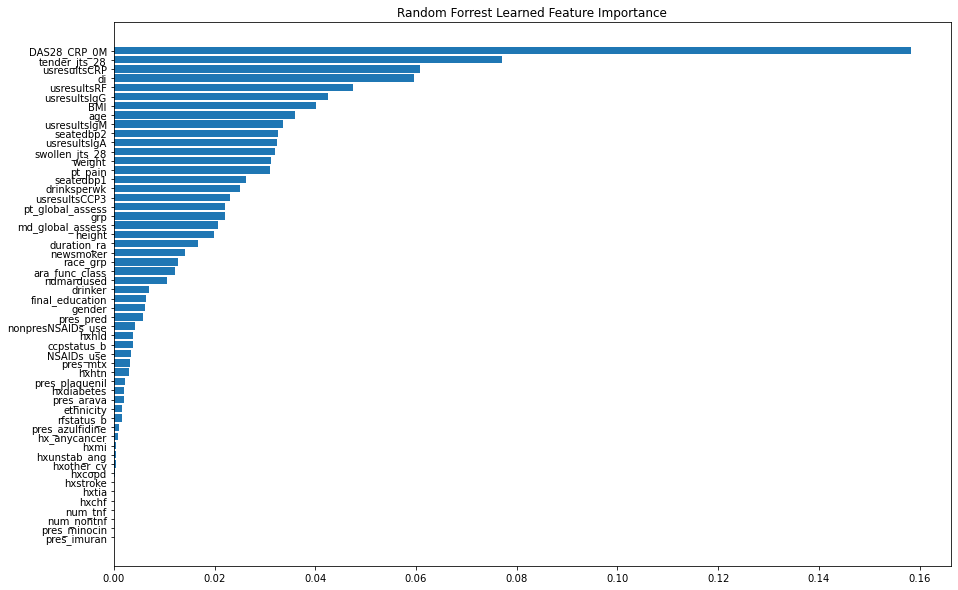

In [39]:

rf = ensemble.RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices= np.argsort(importances)
rf_preds=rf.predict(X_test)
fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])
fig.set_size_inches(15,10)
ax.set_title("Random Forrest Learned Feature Importance")

In [40]:
rf_most_important = ensemble.RandomForestRegressor(n_estimators= 1000)
important = np.array(X_train.columns)[indices][-10:]
features=[x for x in important]
features
#train_important = train_features[:, important_indices]
important_train=X_train[["weight","usresultsIgM", 'age','BMI',
 'usresultsIgG',
 'usresultsRF',
 'di',
 'usresultsCRP',
 'tender_jts_28',
 'DAS28_CRP_0M']]
important_test=X_test[["weight","usresultsIgM", 'age','BMI',
 'usresultsIgG',
 'usresultsRF',
 'di',
 'usresultsCRP',
 'tender_jts_28',
 'DAS28_CRP_0M']]
rf_most_important.fit(important_train, y_train)
important_prerds=rf_most_important.predict(important_test)

In [41]:
aml = evaluate.AutoBuild(seed=1, project_name="EHR_RA_SC")
baseline = test['DAS28_CRP_0M']
true = test['DAS28_CRP_3M']
preds_ridge=ridge_model.predict(X_test)
preds_lasso=lASSO.predict(X_test)
regression, classification = aml.leaderboard()
aml.evaluate("Base Ridge Linear Model", test, ridge_base_preds)
aml.evaluate("Adjusted Ridge Linear Model", test, preds_ridge)
aml.evaluate("Base Lasso Linear Model", test, laso_base_preds)
aml.evaluate("Adjusted Lasso Linear Model",test, preds_lasso)
aml.evaluate("Random Forrest ", test,rf_preds)
aml.evaluate("Random Forrest (only top 10 features)", test, important_prerds)
regression, classification = aml.leaderboard()

In [42]:
regression


,model,MAE,MSE,RMSE,R2,Pearson_Correlation
0,Base Ridge Linear Model,1.022609,1.580530,1.257191,0.197199,0.473213
1,Adjusted Ridge Linear Model,1.013056,1.575134,1.255043,0.199940,0.482950
2,Base Lasso Linear Model,1.075564,1.707964,1.306891,0.132471,0.383525
3,Adjusted Lasso Linear Model,0.978416,1.472689,1.213544,0.251975,0.531591
4,Random Forrest,0.977661,1.395585,1.181349,0.291138,0.609739
5,Random Forrest (only top 10 features),0.987043,1.447425,1.203090,0.264807,0.569207


In [43]:
classification


,model,Accuracy,F1-Score
0,Base Ridge Linear Model,0.453488,0.435112
1,Adjusted Ridge Linear Model,0.476744,0.463623
2,Base Lasso Linear Model,0.418605,0.364713
3,Adjusted Lasso Linear Model,0.488372,0.472984
4,Random Forrest,0.418605,0.353546
5,Random Forrest (only top 10 features),0.476744,0.419751


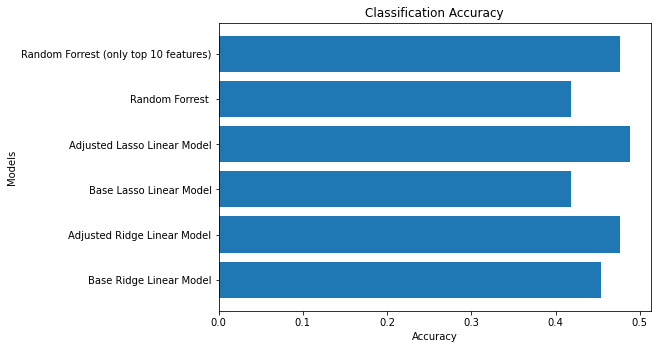

In [50]:
aml.plot_results('classification',metics="Accuracy")



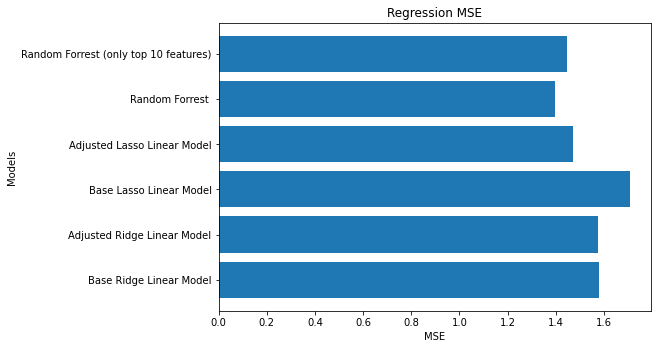

In [49]:
#aml.confusion_matrix("Adjusted Ridge Linear Model")
aml.plot_results(mode='regression',metics="MSE")